# 1. 필요한 라이브러리 불러오기

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from collections import defaultdict
from sklearn import tree, metrics
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(1)

# 2. 데이터 불러오기

In [3]:
test_data = pd.read_csv("./test/test.csv").drop(labels='index', axis=1)
test_label = pd.read_csv("./test/test_label.csv").drop(labels='index', axis=1)
train_data = pd.read_csv("./train/train.csv").drop(labels='index', axis=1)
train_label = pd.read_csv("./train/train_label.csv").drop(labels='index', axis=1)

In [4]:
train = pd.concat([train_data, train_label], axis=1)
test = pd.concat([test_data, test_label], axis=1)

# 3. 데이터 탐색

## 1) 데이터 요약 통계량

In [5]:
train.describe(include="all")

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
count,13228,13228,13228,13228.000000,1.322800e+04,13228,13228,13228,13228,13228.000000,13228.000000,13228.0,13228.000000,13228.000000,13228.000000,9096,13228.000000,13228.000000,13228.000000
unique,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN
top,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN
freq,8795,8251,8823,NaN,NaN,6766,8972,9068,11820,NaN,NaN,NaN,NaN,NaN,NaN,2260,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.428107,1.888212e+05,NaN,NaN,NaN,NaN,-15958.143408,59854.037496,1.0,0.230269,0.296946,0.089507,NaN,2.192773,-26.198292,0.878213
std,NaN,NaN,NaN,0.740691,1.041743e+05,NaN,NaN,NaN,NaN,4199.720373,138166.424477,0.0,0.421021,0.456930,0.285485,NaN,0.910463,16.579604,0.327052
min,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000,-60.000000,0.000000
25%,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19406.500000,-3153.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-40.000000,1.000000
50%,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,-15521.500000,-1539.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-24.000000,1.000000
75%,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12454.000000,-401.750000,1.0,0.000000,1.000000,0.000000,NaN,3.000000,-12.000000,1.000000


## 2) 데이터 시각화

### income_type

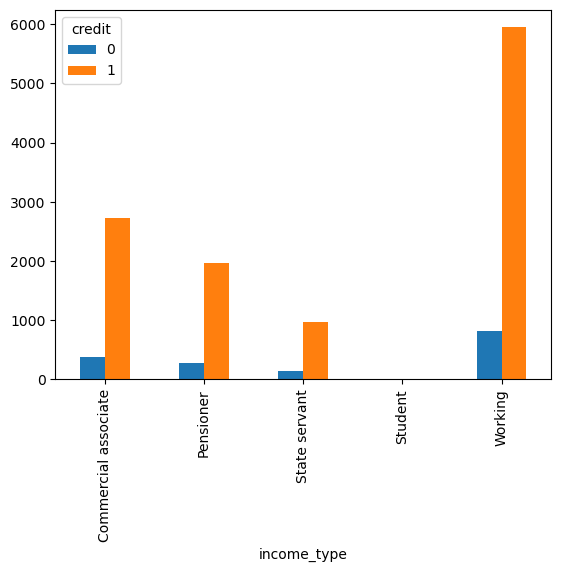

In [6]:
vis1 = train.groupby(['income_type','credit'])['credit'].count().unstack('credit')
vis1.plot(kind='bar')
plt.show()

### edu_type

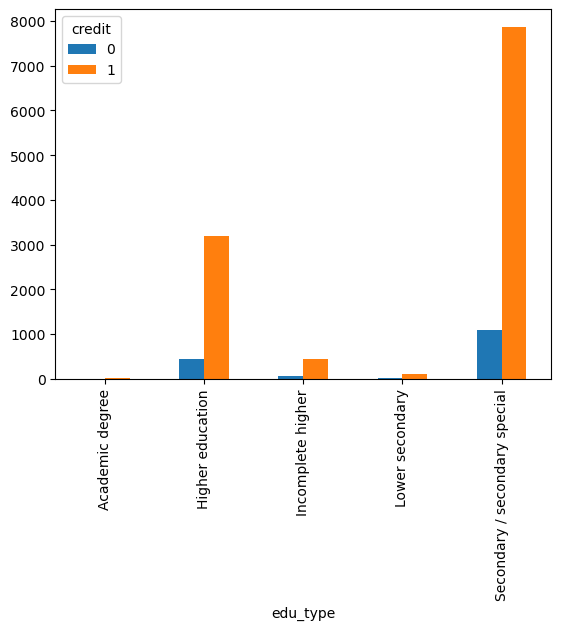

In [7]:
vis2 = train.groupby(['edu_type','credit'])['credit'].count().unstack('credit')
vis2.plot(kind='bar')
plt.show()

### family_type

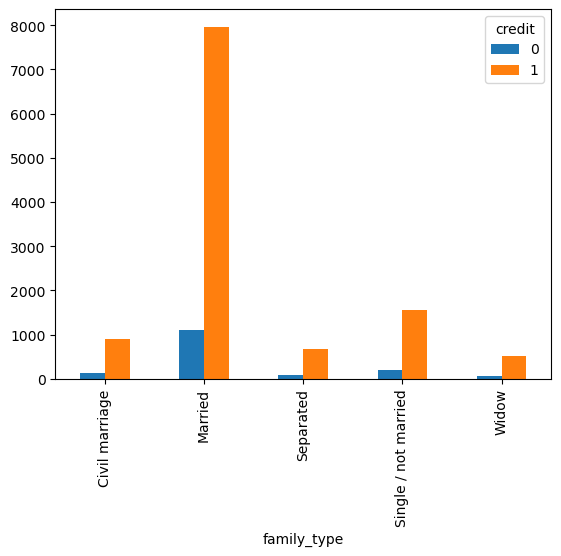

In [8]:
vis3 = train.groupby(['family_type','credit'])['credit'].count().unstack('credit')
vis3.plot(kind='bar')
plt.show()

### house_type

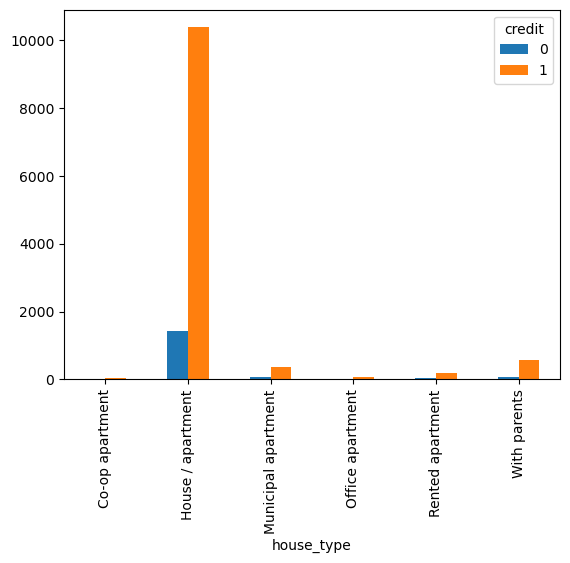

In [9]:
vis4 = train.groupby(['house_type','credit'])['credit'].count().unstack('credit')
vis4.plot(kind='bar')
plt.show()

### occyp_type

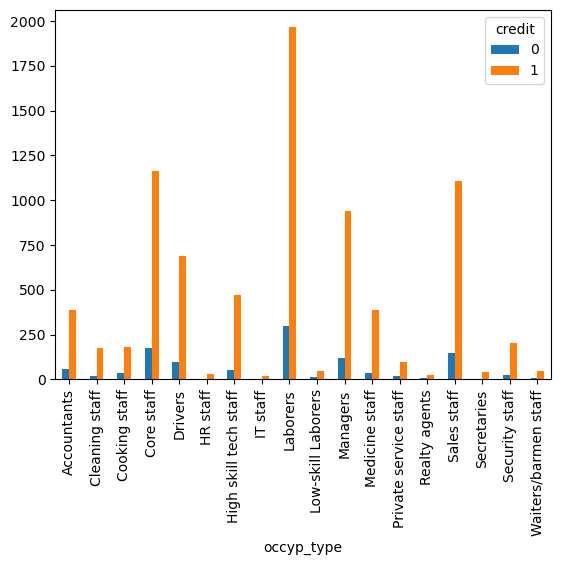

In [10]:
vis5 = train.groupby(['occyp_type','credit'])['credit'].count().unstack('credit')
vis5.plot(kind='bar')
plt.show()

## 3) 데이터 불균형 확인

In [11]:
pos, neg = np.bincount(train['credit'])
print('부정 거래 비율 : {:.3f}%'.format(pos/(pos+neg) *100))

부정 거래 비율 : 12.179%


- 정상 거래에 비해 부정 거래의 비율이 적은 것을 확인
- 정확도(accuracy)와 더불어 재현율(recall)과 f1-score 를 별도의 평가 지표로 사용

# 4. 데이터 전처리

## 1) 결측치 확인 및 최빈값으로 대체

In [12]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       4132
family_size         0
begin_month         0
credit              0
dtype: int64

In [13]:
# 결측치 비율 확인
train['occyp_type'].isnull().sum() / train['occyp_type'].shape[0]

0.3123677048684608

In [14]:
# train_data2 : 결측치 제거된 train_data
# 최빈값으로 대체
train.fillna(train['occyp_type'].mode()[0], inplace=True)

In [15]:
train.isnull().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64

결측치가 더 이상 없음을 확인

## 2) 불필요한 변수 제거

In [16]:
train.describe(include='all')

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
count,13228,13228,13228,13228.000000,1.322800e+04,13228,13228,13228,13228,13228.000000,13228.000000,13228.0,13228.000000,13228.000000,13228.000000,13228,13228.000000,13228.000000,13228.000000
unique,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN
top,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN
freq,8795,8251,8823,NaN,NaN,6766,8972,9068,11820,NaN,NaN,NaN,NaN,NaN,NaN,6392,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.428107,1.888212e+05,NaN,NaN,NaN,NaN,-15958.143408,59854.037496,1.0,0.230269,0.296946,0.089507,NaN,2.192773,-26.198292,0.878213
std,NaN,NaN,NaN,0.740691,1.041743e+05,NaN,NaN,NaN,NaN,4199.720373,138166.424477,0.0,0.421021,0.456930,0.285485,NaN,0.910463,16.579604,0.327052
min,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000,-60.000000,0.000000
25%,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19406.500000,-3153.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-40.000000,1.000000
50%,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,-15521.500000,-1539.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-24.000000,1.000000
75%,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12454.000000,-401.750000,1.0,0.000000,1.000000,0.000000,NaN,3.000000,-12.000000,1.000000


In [17]:
# 모든 데이터의 값이 1로 같은 변수 'FLAG_MOBIL' 제거 (mean, max, min 모두 1로 동일)
train.drop(labels='FLAG_MOBIL', axis=1, inplace=True)

## 3) 범주형 변수 처리 - [1] binary class
- binary class 변수는 0과 1의 정수값으로 class 를 변경

gender ( F:0 , M:1)

In [18]:
train['gender'] = train['gender'].map({'F':0, 'M':1})
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,Y,Y,0,202500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19031,365243,0,0,0,Laborers,2,-53,1
1,0,N,N,1,157500.0,Working,Higher education,Married,House / apartment,-15773,-309,0,1,0,Sales staff,3,-26,0
2,1,Y,N,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-13483,-1816,1,1,0,Laborers,2,-9,1
3,0,Y,N,2,112500.0,Working,Secondary / secondary special,Married,House / apartment,-12270,-150,0,1,0,Security staff,4,-12,1
4,1,Y,Y,1,225000.0,Working,Secondary / secondary special,Married,House / apartment,-16175,-2371,0,0,0,Drivers,3,-3,1


car & reality ( Y:1 , N:0)

In [19]:
train['car'] = train['car'].map({'Y':1, 'N':0})
train['reality'] = train['reality'].map({'Y':1, 'N':0})
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,1,1,0,202500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19031,365243,0,0,0,Laborers,2,-53,1
1,0,0,0,1,157500.0,Working,Higher education,Married,House / apartment,-15773,-309,0,1,0,Sales staff,3,-26,0
2,1,1,0,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-13483,-1816,1,1,0,Laborers,2,-9,1
3,0,1,0,2,112500.0,Working,Secondary / secondary special,Married,House / apartment,-12270,-150,0,1,0,Security staff,4,-12,1
4,1,1,1,1,225000.0,Working,Secondary / secondary special,Married,House / apartment,-16175,-2371,0,0,0,Drivers,3,-3,1


## 4) 다중공선성 - 변수 제거 및 PCA

### 상관계수 heatmap
- 0.7 <= 상관계수 < 1.0 : 두 변수 중 y(credit)과의 상관계수가 낮은 변수 제거
- 0.5 <= 상관계수 < 0.7 : PCA를 통해 변수 특징 추출

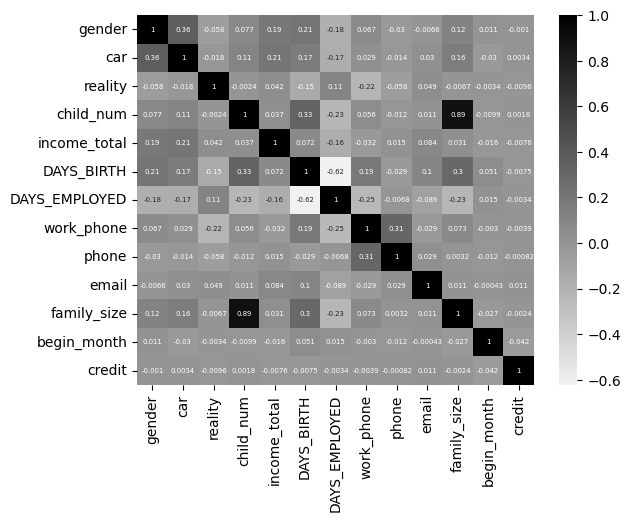

In [20]:
cmap = sns.light_palette(color='black', as_cmap=True)
sns.heatmap(train.corr(), annot=True, annot_kws={'size':5},cmap=cmap)
plt.show()

### 변수 제거
- 입력 변수 간 상관계수가 가장 높은 family_size 와 child_num 중, credit (Y) 와의 상관계수가 낮은 child_num 제거

In [21]:
train.drop(labels='child_num', axis=1, inplace=True)

### PCA (주성분 분석)
- 상관계수가 높은 두 변수 DAYS_BIRTH 와 DAYS_EMPLOYED 를 PCA 를 통해 하나의 변수로 통합

In [22]:
pca_x = train[['DAYS_BIRTH', 'DAYS_EMPLOYED']].values
pca_x = StandardScaler().fit_transform(pca_x)

pca = PCA(n_components=1)
pca_train = pca.fit_transform(pca_x)

train.drop(labels=['DAYS_BIRTH','DAYS_EMPLOYED'], axis=1, inplace=True)
train['DAYS_BIRTH_TO_EMPLOYED'] = pca_train

print('새로운 변수 DAYS_BIRTH_TO_EMPLOYED는 전체 데이터 분산의 {:.2f}% 설명'.format( sum(pca.explained_variance_ratio_)*100 ))

새로운 변수 DAYS_BIRTH_TO_EMPLOYED는 전체 데이터 분산의 81.11% 설명


## 5) 범주형 변수 처리 - [2] multi class
- multi class 범주형 변수의 처리
- 방법1 : One-Hot Encoding -> DNN & LR
- 방법2 : Label Encoding -> DT

### [방법1] One-Hot Encoding : DNN & LR

In [23]:
train1 = pd.get_dummies(train, columns = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])

In [24]:
train1.dtypes

gender                                      int64
car                                         int64
reality                                     int64
income_total                              float64
work_phone                                  int64
phone                                       int64
email                                       int64
family_size                                 int64
begin_month                                 int64
credit                                      int64
DAYS_BIRTH_TO_EMPLOYED                    float64
income_type_Commercial associate            uint8
income_type_Pensioner                       uint8
income_type_State servant                   uint8
income_type_Student                         uint8
income_type_Working                         uint8
edu_type_Academic degree                    uint8
edu_type_Higher education                   uint8
edu_type_Incomplete higher                  uint8
edu_type_Lower secondary                    uint8


### [방법 2] Label Encoding - DT

In [25]:
train2 = train.copy()
for col in list(train.columns):
    if train[col].dtypes == 'object':
        le = LabelEncoder()
        train2[col] = le.fit_transform(train2[col])
train2.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,DAYS_BIRTH_TO_EMPLOYED
0,0,1,1,202500.0,1,4,1,1,0,0,0,8,2,-53,1,2.080372
1,0,0,0,157500.0,4,1,1,1,0,1,0,14,3,-26,0,-0.339087
2,1,1,0,135000.0,4,4,1,1,1,1,0,8,2,-9,1,-0.732382
3,0,1,0,112500.0,4,4,1,1,0,1,0,16,4,-12,1,-0.928096
4,1,1,1,225000.0,4,4,1,1,0,0,0,4,3,-3,1,-0.281953


# 5. DNN / DT / LR

## 5-1) DNN

### 변수 저장 및 스케일링 (MinMaxScaling)

In [26]:
x51 = train1.drop(['credit'], axis=1, inplace=False)
y51 = train1['credit']

train_x51, val_x51, train_y51, val_y51 = train_test_split(x51, y51, train_size=0.8, random_state=1, stratify=y51)

scaler51 = MinMaxScaler()
scaler51.fit(train_x51)

train_x51 = pd.DataFrame(scaler51.transform(train_x51), columns = train_x51.columns)
val_x51 = pd.DataFrame(scaler51.transform(val_x51), columns = val_x51.columns)

In [27]:
train_y51 = tf.keras.utils.to_categorical(train_y51, num_classes=2)
val_y51 = tf.keras.utils.to_categorical(val_y51, num_classes=2)

### DNN 모델 찾기
- 검증 데이터에 대한 정확도를 가장 높일 수 있는 최적의 epoch 횟수 찾기

In [28]:
train_x51.shape

(10582, 49)

In [29]:
def getDNN(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)

    x = tf.keras.layers.Dense(15)(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Dense(12)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(12)(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Dense(2)(x)
    
    outputs = tf.keras.layers.Activation('sigmoid')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [30]:
DNN = getDNN((49,49))
DNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

2022-11-25 19:50:39.528312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
DNNlearn = DNN.fit(train_x51, train_y51, epochs = 500, batch_size=100, validation_split=0.2, verbose = 1)

Epoch 1/500
85/85 [==============================] - 0s 2ms/step - loss: 0.4513 - acc: 0.8800 - val_loss: 0.3905 - val_acc: 0.8710
Epoch 2/500
85/85 [==============================] - 0s 764us/step - loss: 0.3691 - acc: 0.8800 - val_loss: 0.3886 - val_acc: 0.8710
Epoch 3/500
85/85 [==============================] - 0s 711us/step - loss: 0.3674 - acc: 0.8800 - val_loss: 0.3879 - val_acc: 0.8710
Epoch 4/500
85/85 [==============================] - 0s 730us/step - loss: 0.3660 - acc: 0.8800 - val_loss: 0.3881 - val_acc: 0.8710
Epoch 5/500
85/85 [==============================] - 0s 699us/step - loss: 0.3651 - acc: 0.8800 - val_loss: 0.3901 - val_acc: 0.8710
Epoch 6/500
85/85 [==============================] - 0s 683us/step - loss: 0.3650 - acc: 0.8800 - val_loss: 0.3871 - val_acc: 0.8710
Epoch 7/500
85/85 [==============================] - 0s 721us/step - loss: 0.3637 - acc: 0.8800 - val_loss: 0.3869 - val_acc: 0.8710
Epoch 8/500
85/85 [==============================] - 0s 748us/step - lo

85/85 [==============================] - 0s 707us/step - loss: 0.3091 - acc: 0.8874 - val_loss: 0.4269 - val_acc: 0.8687
Epoch 117/500
85/85 [==============================] - 0s 744us/step - loss: 0.3092 - acc: 0.8871 - val_loss: 0.4259 - val_acc: 0.8677
Epoch 118/500
85/85 [==============================] - 0s 716us/step - loss: 0.3081 - acc: 0.8867 - val_loss: 0.4212 - val_acc: 0.8649
Epoch 119/500
85/85 [==============================] - 0s 706us/step - loss: 0.3089 - acc: 0.8872 - val_loss: 0.4272 - val_acc: 0.8663
Epoch 120/500
85/85 [==============================] - 0s 678us/step - loss: 0.3085 - acc: 0.8867 - val_loss: 0.4262 - val_acc: 0.8635
Epoch 121/500
85/85 [==============================] - 0s 739us/step - loss: 0.3085 - acc: 0.8867 - val_loss: 0.4280 - val_acc: 0.8668
Epoch 122/500
85/85 [==============================] - 0s 713us/step - loss: 0.3080 - acc: 0.8865 - val_loss: 0.4310 - val_acc: 0.8649
Epoch 123/500
85/85 [==============================] - 0s 735us/step 

Epoch 177/500
85/85 [==============================] - 0s 736us/step - loss: 0.2976 - acc: 0.8907 - val_loss: 0.4439 - val_acc: 0.8658
Epoch 178/500
85/85 [==============================] - 0s 729us/step - loss: 0.2959 - acc: 0.8914 - val_loss: 0.4452 - val_acc: 0.8611
Epoch 179/500
85/85 [==============================] - 0s 812us/step - loss: 0.2959 - acc: 0.8914 - val_loss: 0.4476 - val_acc: 0.8644
Epoch 180/500
85/85 [==============================] - 0s 730us/step - loss: 0.2950 - acc: 0.8916 - val_loss: 0.4462 - val_acc: 0.8621
Epoch 181/500
85/85 [==============================] - 0s 715us/step - loss: 0.2971 - acc: 0.8910 - val_loss: 0.4455 - val_acc: 0.8663
Epoch 182/500
85/85 [==============================] - 0s 742us/step - loss: 0.2954 - acc: 0.8927 - val_loss: 0.4644 - val_acc: 0.8663
Epoch 183/500
85/85 [==============================] - 0s 731us/step - loss: 0.2952 - acc: 0.8913 - val_loss: 0.4499 - val_acc: 0.8649
Epoch 184/500
85/85 [==============================] - 

Epoch 238/500
85/85 [==============================] - 0s 727us/step - loss: 0.2877 - acc: 0.8908 - val_loss: 0.4634 - val_acc: 0.8621
Epoch 239/500
85/85 [==============================] - 0s 737us/step - loss: 0.2875 - acc: 0.8938 - val_loss: 0.4668 - val_acc: 0.8625
Epoch 240/500
85/85 [==============================] - 0s 754us/step - loss: 0.2868 - acc: 0.8923 - val_loss: 0.4696 - val_acc: 0.8640
Epoch 241/500
85/85 [==============================] - 0s 732us/step - loss: 0.2867 - acc: 0.8939 - val_loss: 0.4673 - val_acc: 0.8611
Epoch 242/500
85/85 [==============================] - 0s 716us/step - loss: 0.2864 - acc: 0.8923 - val_loss: 0.4700 - val_acc: 0.8621
Epoch 243/500
85/85 [==============================] - 0s 747us/step - loss: 0.2878 - acc: 0.8930 - val_loss: 0.4724 - val_acc: 0.8616
Epoch 244/500
85/85 [==============================] - 0s 753us/step - loss: 0.2874 - acc: 0.8918 - val_loss: 0.4722 - val_acc: 0.8621
Epoch 245/500
85/85 [==============================] - 

Epoch 299/500
85/85 [==============================] - 0s 755us/step - loss: 0.2818 - acc: 0.8942 - val_loss: 0.4886 - val_acc: 0.8658
Epoch 300/500
85/85 [==============================] - 0s 710us/step - loss: 0.2815 - acc: 0.8946 - val_loss: 0.4828 - val_acc: 0.8630
Epoch 301/500
85/85 [==============================] - 0s 709us/step - loss: 0.2823 - acc: 0.8925 - val_loss: 0.4935 - val_acc: 0.8649
Epoch 302/500
85/85 [==============================] - 0s 696us/step - loss: 0.2803 - acc: 0.8943 - val_loss: 0.4852 - val_acc: 0.8583
Epoch 303/500
85/85 [==============================] - 0s 729us/step - loss: 0.2791 - acc: 0.8943 - val_loss: 0.4807 - val_acc: 0.8611
Epoch 304/500
85/85 [==============================] - 0s 746us/step - loss: 0.2796 - acc: 0.8949 - val_loss: 0.4799 - val_acc: 0.8611
Epoch 305/500
85/85 [==============================] - 0s 735us/step - loss: 0.2792 - acc: 0.8950 - val_loss: 0.4900 - val_acc: 0.8654
Epoch 306/500
85/85 [==============================] - 

Epoch 360/500
85/85 [==============================] - 0s 720us/step - loss: 0.2769 - acc: 0.8937 - val_loss: 0.4918 - val_acc: 0.8588
Epoch 361/500
85/85 [==============================] - 0s 708us/step - loss: 0.2763 - acc: 0.8957 - val_loss: 0.4974 - val_acc: 0.8621
Epoch 362/500
85/85 [==============================] - 0s 752us/step - loss: 0.2758 - acc: 0.8955 - val_loss: 0.5015 - val_acc: 0.8640
Epoch 363/500
85/85 [==============================] - 0s 738us/step - loss: 0.2760 - acc: 0.8943 - val_loss: 0.4989 - val_acc: 0.8630
Epoch 364/500
85/85 [==============================] - 0s 726us/step - loss: 0.2758 - acc: 0.8962 - val_loss: 0.4965 - val_acc: 0.8597
Epoch 365/500
85/85 [==============================] - 0s 712us/step - loss: 0.2747 - acc: 0.8966 - val_loss: 0.5034 - val_acc: 0.8640
Epoch 366/500
85/85 [==============================] - 0s 773us/step - loss: 0.2755 - acc: 0.8942 - val_loss: 0.4993 - val_acc: 0.8597
Epoch 367/500
85/85 [==============================] - 

Epoch 421/500
85/85 [==============================] - 0s 762us/step - loss: 0.2734 - acc: 0.8945 - val_loss: 0.5134 - val_acc: 0.8640
Epoch 422/500
85/85 [==============================] - 0s 726us/step - loss: 0.2711 - acc: 0.8950 - val_loss: 0.5089 - val_acc: 0.8625
Epoch 423/500
85/85 [==============================] - 0s 849us/step - loss: 0.2725 - acc: 0.8962 - val_loss: 0.5051 - val_acc: 0.8573
Epoch 424/500
85/85 [==============================] - 0s 735us/step - loss: 0.2724 - acc: 0.8959 - val_loss: 0.5074 - val_acc: 0.8592
Epoch 425/500
85/85 [==============================] - 0s 747us/step - loss: 0.2735 - acc: 0.8955 - val_loss: 0.5180 - val_acc: 0.8649
Epoch 426/500
85/85 [==============================] - 0s 717us/step - loss: 0.2715 - acc: 0.8955 - val_loss: 0.4986 - val_acc: 0.8545
Epoch 427/500
85/85 [==============================] - 0s 716us/step - loss: 0.2725 - acc: 0.8950 - val_loss: 0.5028 - val_acc: 0.8569
Epoch 428/500
85/85 [==============================] - 

Epoch 482/500
85/85 [==============================] - 0s 748us/step - loss: 0.2688 - acc: 0.8978 - val_loss: 0.5098 - val_acc: 0.8559
Epoch 483/500
85/85 [==============================] - 0s 718us/step - loss: 0.2720 - acc: 0.8962 - val_loss: 0.5068 - val_acc: 0.8488
Epoch 484/500
85/85 [==============================] - 0s 730us/step - loss: 0.2701 - acc: 0.8963 - val_loss: 0.5072 - val_acc: 0.8460
Epoch 485/500
85/85 [==============================] - 0s 729us/step - loss: 0.2716 - acc: 0.8972 - val_loss: 0.5095 - val_acc: 0.8569
Epoch 486/500
85/85 [==============================] - 0s 742us/step - loss: 0.2688 - acc: 0.8966 - val_loss: 0.5165 - val_acc: 0.8602
Epoch 487/500
85/85 [==============================] - 0s 731us/step - loss: 0.2708 - acc: 0.8964 - val_loss: 0.5111 - val_acc: 0.8550
Epoch 488/500
85/85 [==============================] - 0s 737us/step - loss: 0.2685 - acc: 0.8964 - val_loss: 0.5186 - val_acc: 0.8607
Epoch 489/500
85/85 [==============================] - 

In [32]:
def plotDNN(dnnlearn):
    plt.figure(figsize=(15, 7))

    plt.subplot(1,2,1)
    plt.title('validation loss')
    plt.plot(dnnlearn.history['loss'], label='loss')
    plt.plot(dnnlearn.history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('accuracy')
    plt.plot(dnnlearn.history['acc'], label='acc')
    plt.plot(dnnlearn.history['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

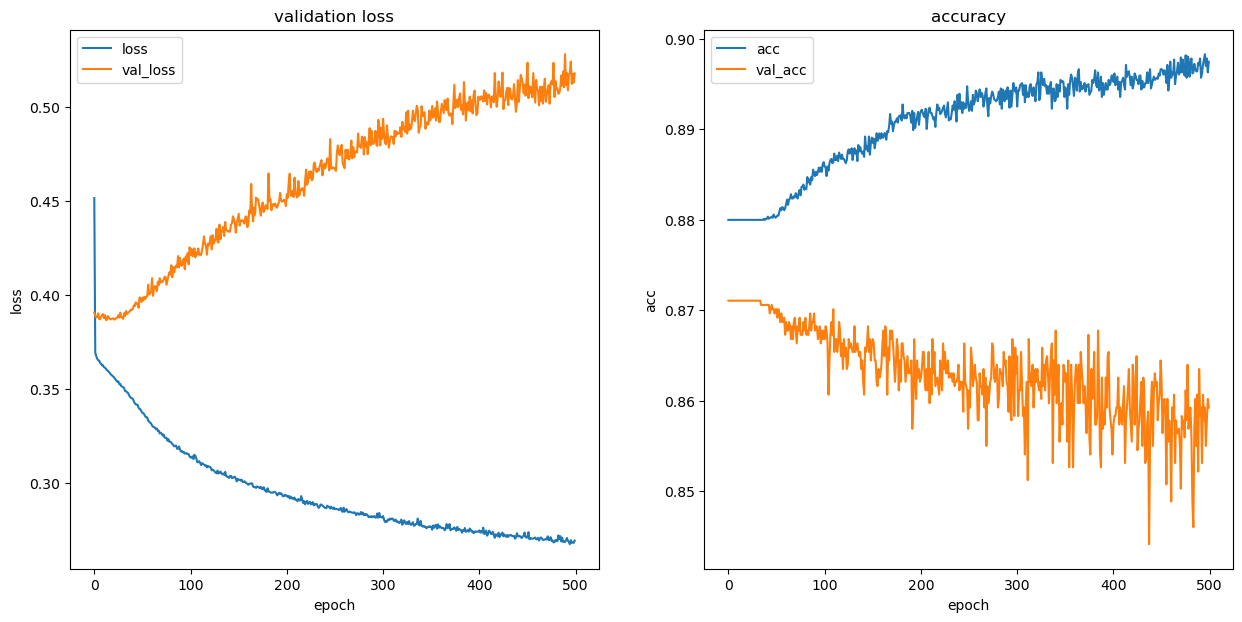

In [33]:
plotDNN(DNNlearn)

- epoch 횟수가 약 50회를 넘는 시점부터 학습 데이터에 대해 accuracy가 급격히 하락하며, 과적합 됨을 확인할 수 있음
- epoch = 50 으로 다시 두고 모델 재실행

### DNN 모델 생성 및 실행

In [34]:
# 이 블럭의 코드는 위와 반복되므로 ppt 에 첨부할 필요 없음

# (1) 변수 생성 및 최적화
x512 = train1.drop(['credit'], axis=1, inplace=False)
y512 = train1['credit']

train_x512, val_x512, train_y512, val_y512 = train_test_split(x512, y512, train_size=0.8, random_state=1, stratify=y512)

scaler512 = MinMaxScaler()
scaler512.fit(train_x512)

train_x512 = pd.DataFrame(scaler512.transform(train_x512), columns = train_x512.columns)
val_x512 = pd.DataFrame(scaler512.transform(val_x512), columns = val_x512.columns)

train_y512 = tf.keras.utils.to_categorical(train_y512, num_classes=2)
val_y512 = tf.keras.utils.to_categorical(val_y512, num_classes=2)

# (2) DNN 모델 생성
DNN_epoch50 = getDNN((49,49))
DNN_epoch50.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

#### epoch = 50 으로 두고 모델 실행

In [35]:
NNlearn_epoch50 = DNN_epoch50.fit(train_x512, train_y512, epochs = 50, batch_size=100, validation_split=0.2, verbose = 1)

Epoch 1/50
85/85 [==============================] - 0s 2ms/step - loss: 0.5311 - acc: 0.8070 - val_loss: 0.3899 - val_acc: 0.8710
Epoch 2/50
85/85 [==============================] - 0s 765us/step - loss: 0.3727 - acc: 0.8800 - val_loss: 0.3855 - val_acc: 0.8710
Epoch 3/50
85/85 [==============================] - 0s 741us/step - loss: 0.3699 - acc: 0.8800 - val_loss: 0.3856 - val_acc: 0.8710
Epoch 4/50
85/85 [==============================] - 0s 782us/step - loss: 0.3678 - acc: 0.8800 - val_loss: 0.3852 - val_acc: 0.8710
Epoch 5/50
85/85 [==============================] - 0s 749us/step - loss: 0.3667 - acc: 0.8800 - val_loss: 0.3867 - val_acc: 0.8710
Epoch 6/50
85/85 [==============================] - 0s 734us/step - loss: 0.3654 - acc: 0.8800 - val_loss: 0.3859 - val_acc: 0.8710
Epoch 7/50
85/85 [==============================] - 0s 719us/step - loss: 0.3649 - acc: 0.8800 - val_loss: 0.3861 - val_acc: 0.8710
Epoch 8/50
85/85 [==============================] - 0s 746us/step - loss: 0.36

In [36]:
DNNevaluate = DNN_epoch50.evaluate(val_x512, val_y512)
print("loss = {:.5f} / accuracy = {:.5f}".format(DNNevaluate[0],DNNevaluate[1]))

83/83 [==============================] - 0s 394us/step - loss: 0.3789 - acc: 0.8783
loss = 0.37887 / accuracy = 0.87831


### 혼동행렬

In [37]:
def getCFmat(DNNmodel, val_x, val_y):
    DNNpred = DNNmodel.predict(val_x)
    DNNpred = np.argmax(DNNpred, axis=1)
    DNNtrue = np.argmax(val_y, axis=1)
    
    DNNmatrix = confusion_matrix(DNNtrue, DNNpred, labels=range(2))
    CFmat = pd.DataFrame(DNNmatrix, columns=range(2), index=range(2))
    
    plt.figure(figsize=(8, 8))
    plt.title('confusion matrix')
    sns.heatmap(CFmat, annot=True, fmt='d', square=True, cmap='Blues')
    plt.xlabel('pred')
    plt.ylabel('true')
    plt.show()
    
    DNN_TN, DNN_FP, DNN_FN, DNN_TP = CFmat[0][0], CFmat[1][0], CFmat[0][1], CFmat[1][1]

    DNNrecall = DNN_TP / (DNN_TP+DNN_FN)
    DNNprecision = DNN_TP / (DNN_TP+DNN_FP)
    DNNf1 = 2*DNNrecall*DNNprecision/(DNNprecision+DNNrecall)

    print("DNN Accuracy for validation data\t: {:.5f}".format(DNNevaluate[1]))
    print("DNN Recall for validation data\t\t: {:.5f}".format(DNNrecall))
    print("DNN F1 score for validation data\t: {:.5f}".format(DNNf1))

83/83 [==============================] - 0s 331us/step


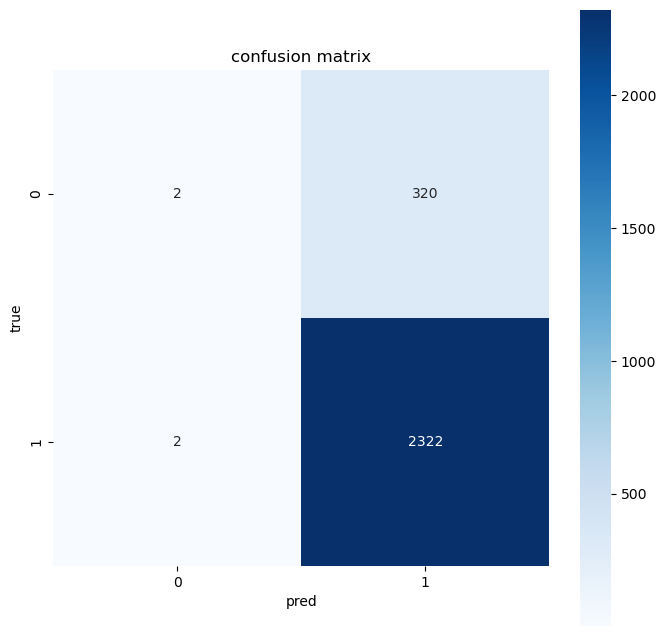

DNN Accuracy for validation data	: 0.87831
DNN Recall for validation data		: 0.99914
DNN F1 score for validation data	: 0.93516


In [38]:
getCFmat(DNN_epoch50, val_x512, val_y512)

## 5-2) DT

### 변수 저장

In [39]:
x52 = train2.drop(['credit'], axis=1, inplace=False)
y52 = train2['credit'].astype('int')

train_x52, val_x52, train_y52, val_y52 = train_test_split(x52, y52, train_size=0.8, random_state=1, stratify=y52)

### 의사결정나무 모델 생성
- GridSearchCV 를 통해서 Decision Tree 모델에 대해 학습 데이터를 이용하여 최적의 하이퍼파라미터 탐색
- 하이퍼 파라미터 후보 : criterion = {gini, entropy} / max_depth = {2, 3, 4, 5, None} / random_state = 1
- 평가 지표 : F1-Score

In [40]:
DT_search = tree.DecisionTreeClassifier()

param_dt = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2, 3, 4, 5, None],
    'random_state' : [1]
}

gscv_dt = GridSearchCV(estimator=DT_search, param_grid=param_dt, scoring='f1', cv=5)

gscv_dt.fit(train_x52, train_y52)

print("F1 score = {:.5f}".format(gscv_dt.best_score_))
print("parameters =", gscv_dt.best_params_)

F1 score = 0.93514
parameters = {'criterion': 'gini', 'max_depth': 2, 'random_state': 1}


- 최적의 파라미터로 Decision Tree 모델 생성

In [41]:
DT = tree.DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=1)

In [42]:
DT.fit(train_x52, train_y52)

DecisionTreeClassifier(max_depth=2, random_state=1)

[Text(0.5, 0.8333333333333334, 'begin_month <= -6.5\ngini = 0.214\nsamples = 10582\nvalue = [1289, 9293]'),
 Text(0.25, 0.5, 'DAYS_BIRTH_TO_EMPLOYED <= -1.204\ngini = 0.2\nsamples = 9208\nvalue = [1039, 8169]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.156\nsamples = 1007\nvalue = [86, 921]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.205\nsamples = 8201\nvalue = [953, 7248]'),
 Text(0.75, 0.5, 'begin_month <= -0.5\ngini = 0.298\nsamples = 1374\nvalue = [250, 1124]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.288\nsamples = 1291\nvalue = [225, 1066]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.421\nsamples = 83\nvalue = [25, 58]')]

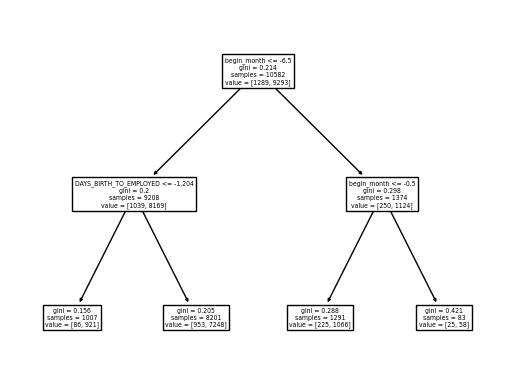

In [43]:
tree.plot_tree(DT, feature_names = train_x52.columns)

In [44]:
print("Decision Tree Accuracy for validation data\t: {:.5f}".format(accuracy_score(val_y52, DT.predict(val_x52))))
print("Decision Tree Recall for validation data\t: {:.5f}".format(recall_score(val_y52, DT.predict(val_x52))))
print("Decision Tree F1 score for validation data\t: {:.5f}".format(f1_score(val_y52, DT.predict(val_x52))))

Decision Tree Accuracy for validation data	: 0.87831
Decision Tree Recall for validation data	: 1.00000
Decision Tree F1 score for validation data	: 0.93521


## 5-3) LR

### 변수 저장 및 스케일링

In [45]:
x53 = train1.drop(['credit'], axis=1, inplace=False)
y53 = train1['credit']

### Logistic Regression 모델 생성 및 실행

In [46]:
def getLR(x, y):
    train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.8, random_state=1, stratify=y)
    
    SDscaler = StandardScaler()
    SDscaler.fit(train_x)
    
    train_x = pd.DataFrame(SDscaler.transform(train_x), columns = train_x.columns)
    val_x = pd.DataFrame(SDscaler.transform(val_x), columns = val_x.columns)
    
    KF = KFold(n_splits=10, shuffle=True, random_state=1)
    LR = LogisticRegression(max_iter=100000)
    LR.fit(train_x, train_y.astype('int'))

    LR_recall = np.mean(cross_val_score(LR, train_x, train_y.astype('int'), scoring='recall', cv=KF))
    LR_accuracy = np.mean(cross_val_score(LR, train_x, train_y.astype('int'), scoring='accuracy', cv=KF))
    LR_f1score = np.mean(cross_val_score(LR, train_x, train_y.astype('int'), scoring='f1', cv=KF))

    print("Logistic Regression Accuracy for train data\t: {:.5f}".format(LR_accuracy))
    print("Logistic Regression Recall for train data\t: {:.5f}".format(LR_recall))
    print("Logistic Regression F1 score for train data\t: {:.5f}".format(LR_f1score))
    print()
    print("Logistic Regression Accuracy for validation data: {:.5f}".format(accuracy_score(val_y, LR.predict(val_x))))
    print("Logistic Regression Recall for validation data\t: {:.5f}".format(recall_score(val_y, LR.predict(val_x))))
    print("Logistic Regression F1 score for validation data: {:.5f}".format(f1_score(val_y, LR.predict(val_x))))


In [47]:
getLR(x53, y53)

Logistic Regression Accuracy for train data	: 0.87819
Logistic Regression Recall for train data	: 1.00000
Logistic Regression F1 score for train data	: 0.93513

Logistic Regression Accuracy for validation data: 0.87831
Logistic Regression Recall for validation data	: 1.00000
Logistic Regression F1 score for validation data: 0.93521


# 6. Clustering Analysis + DNN / DT / LR

### 변수 저장 및 Clustering Analysis 진행
- DNN & LR 은 One-Hot Encoding, DT는 Label Encoding 으로 범주형 변수의 처리 방법이 다르므로 train set 을 나누어 각각 Clustering Analysis 진행

In [48]:
## train set for DNN & LR
x6_1 = train1.drop(labels='credit', axis=1, inplace=False)
y6_1 = train1['credit']

clust_model1 = KMeans(n_clusters =2)
pred6_1 = clust_model1.fit_predict(x6_1)

x6_1['cluster'] = pred6_1

## train set for DT
x6_2 = train2.drop(labels='credit', axis=1, inplace=False)
y6_2 = train2['credit']

clust_model2 = KMeans(n_clusters = 2)
pred6_2 = clust_model2.fit_predict(x6_2)

x6_2['cluster'] = pred6_2

## 6-1) CA + DNN

In [49]:
x61 = x6_1.copy()
y61 = y6_1.copy()

train_x61, val_x61, train_y61, val_y61 = train_test_split(x61, y61, train_size=0.8, random_state=1, stratify=y61)

scaler61 = MinMaxScaler()
scaler61.fit(train_x61)

train_x61 = pd.DataFrame(scaler61.transform(train_x61), columns = train_x61.columns)
val_x61 = pd.DataFrame(scaler61.transform(val_x61), columns = val_x61.columns)

In [50]:
train_y61 = tf.keras.utils.to_categorical(train_y61, num_classes=2)
val_y61 = tf.keras.utils.to_categorical(val_y61, num_classes=2)

### DNN 모델 찾기
- 검증 데이터에 대한 정확도를 가장 높일 수 있는 최적의 epoch 횟수 찾기

In [51]:
train_x61.shape

(10582, 50)

In [52]:
DNN2 = getDNN((50,50))
DNN2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

In [53]:
DNNlearn2 = DNN2.fit(train_x61, train_y61, epochs = 500, batch_size=100, validation_split=0.2, verbose = 1)

Epoch 1/500
85/85 [==============================] - 0s 1ms/step - loss: 0.5838 - acc: 0.7738 - val_loss: 0.4108 - val_acc: 0.8710
Epoch 2/500
85/85 [==============================] - 0s 765us/step - loss: 0.3723 - acc: 0.8800 - val_loss: 0.3908 - val_acc: 0.8710
Epoch 3/500
85/85 [==============================] - 0s 777us/step - loss: 0.3694 - acc: 0.8800 - val_loss: 0.3890 - val_acc: 0.8710
Epoch 4/500
85/85 [==============================] - 0s 736us/step - loss: 0.3677 - acc: 0.8800 - val_loss: 0.3907 - val_acc: 0.8710
Epoch 5/500
85/85 [==============================] - 0s 732us/step - loss: 0.3676 - acc: 0.8800 - val_loss: 0.3882 - val_acc: 0.8710
Epoch 6/500
85/85 [==============================] - 0s 723us/step - loss: 0.3662 - acc: 0.8800 - val_loss: 0.3876 - val_acc: 0.8710
Epoch 7/500
85/85 [==============================] - 0s 706us/step - loss: 0.3655 - acc: 0.8800 - val_loss: 0.3872 - val_acc: 0.8710
Epoch 8/500
85/85 [==============================] - 0s 769us/step - lo

85/85 [==============================] - 0s 728us/step - loss: 0.3132 - acc: 0.8893 - val_loss: 0.3990 - val_acc: 0.8701
Epoch 117/500
85/85 [==============================] - 0s 741us/step - loss: 0.3125 - acc: 0.8887 - val_loss: 0.4064 - val_acc: 0.8696
Epoch 118/500
85/85 [==============================] - 0s 715us/step - loss: 0.3115 - acc: 0.8893 - val_loss: 0.4006 - val_acc: 0.8720
Epoch 119/500
85/85 [==============================] - 0s 703us/step - loss: 0.3118 - acc: 0.8907 - val_loss: 0.4020 - val_acc: 0.8696
Epoch 120/500
85/85 [==============================] - 0s 900us/step - loss: 0.3130 - acc: 0.8892 - val_loss: 0.4007 - val_acc: 0.8696
Epoch 121/500
85/85 [==============================] - 0s 731us/step - loss: 0.3112 - acc: 0.8894 - val_loss: 0.3979 - val_acc: 0.8701
Epoch 122/500
85/85 [==============================] - 0s 732us/step - loss: 0.3110 - acc: 0.8912 - val_loss: 0.4029 - val_acc: 0.8710
Epoch 123/500
85/85 [==============================] - 0s 721us/step 

Epoch 177/500
85/85 [==============================] - 0s 696us/step - loss: 0.3007 - acc: 0.8917 - val_loss: 0.4013 - val_acc: 0.8644
Epoch 178/500
85/85 [==============================] - 0s 687us/step - loss: 0.3008 - acc: 0.8910 - val_loss: 0.4001 - val_acc: 0.8682
Epoch 179/500
85/85 [==============================] - 0s 711us/step - loss: 0.3008 - acc: 0.8916 - val_loss: 0.3992 - val_acc: 0.8668
Epoch 180/500
85/85 [==============================] - 0s 698us/step - loss: 0.3011 - acc: 0.8911 - val_loss: 0.3977 - val_acc: 0.8654
Epoch 181/500
85/85 [==============================] - 0s 692us/step - loss: 0.3011 - acc: 0.8919 - val_loss: 0.4004 - val_acc: 0.8682
Epoch 182/500
85/85 [==============================] - 0s 692us/step - loss: 0.3002 - acc: 0.8923 - val_loss: 0.4001 - val_acc: 0.8677
Epoch 183/500
85/85 [==============================] - 0s 690us/step - loss: 0.2989 - acc: 0.8937 - val_loss: 0.4013 - val_acc: 0.8696
Epoch 184/500
85/85 [==============================] - 

Epoch 238/500
85/85 [==============================] - 0s 691us/step - loss: 0.2926 - acc: 0.8925 - val_loss: 0.4082 - val_acc: 0.8668
Epoch 239/500
85/85 [==============================] - 0s 694us/step - loss: 0.2922 - acc: 0.8936 - val_loss: 0.4052 - val_acc: 0.8706
Epoch 240/500
85/85 [==============================] - 0s 697us/step - loss: 0.2922 - acc: 0.8932 - val_loss: 0.4113 - val_acc: 0.8720
Epoch 241/500
85/85 [==============================] - 0s 1ms/step - loss: 0.2924 - acc: 0.8937 - val_loss: 0.4090 - val_acc: 0.8677
Epoch 242/500
85/85 [==============================] - 0s 714us/step - loss: 0.2920 - acc: 0.8952 - val_loss: 0.4156 - val_acc: 0.8592
Epoch 243/500
85/85 [==============================] - 0s 705us/step - loss: 0.2914 - acc: 0.8940 - val_loss: 0.4084 - val_acc: 0.8729
Epoch 244/500
85/85 [==============================] - 0s 703us/step - loss: 0.2919 - acc: 0.8930 - val_loss: 0.4084 - val_acc: 0.8706
Epoch 245/500
85/85 [==============================] - 0s

Epoch 299/500
85/85 [==============================] - 0s 686us/step - loss: 0.2863 - acc: 0.8951 - val_loss: 0.4198 - val_acc: 0.8654
Epoch 300/500
85/85 [==============================] - 0s 685us/step - loss: 0.2863 - acc: 0.8976 - val_loss: 0.4158 - val_acc: 0.8696
Epoch 301/500
85/85 [==============================] - 0s 1ms/step - loss: 0.2880 - acc: 0.8950 - val_loss: 0.4145 - val_acc: 0.8673
Epoch 302/500
85/85 [==============================] - 0s 760us/step - loss: 0.2879 - acc: 0.8934 - val_loss: 0.4192 - val_acc: 0.8682
Epoch 303/500
85/85 [==============================] - 0s 740us/step - loss: 0.2873 - acc: 0.8965 - val_loss: 0.4238 - val_acc: 0.8640
Epoch 304/500
85/85 [==============================] - 0s 705us/step - loss: 0.2866 - acc: 0.8953 - val_loss: 0.4152 - val_acc: 0.8692
Epoch 305/500
85/85 [==============================] - 0s 696us/step - loss: 0.2859 - acc: 0.8965 - val_loss: 0.4215 - val_acc: 0.8687
Epoch 306/500
85/85 [==============================] - 0s

Epoch 360/500
85/85 [==============================] - 0s 696us/step - loss: 0.2848 - acc: 0.8964 - val_loss: 0.4319 - val_acc: 0.8649
Epoch 361/500
85/85 [==============================] - 0s 706us/step - loss: 0.2837 - acc: 0.8958 - val_loss: 0.4293 - val_acc: 0.8673
Epoch 362/500
85/85 [==============================] - 0s 749us/step - loss: 0.2832 - acc: 0.8959 - val_loss: 0.4293 - val_acc: 0.8649
Epoch 363/500
85/85 [==============================] - 0s 731us/step - loss: 0.2837 - acc: 0.8969 - val_loss: 0.4300 - val_acc: 0.8668
Epoch 364/500
85/85 [==============================] - 0s 695us/step - loss: 0.2820 - acc: 0.8972 - val_loss: 0.4303 - val_acc: 0.8715
Epoch 365/500
85/85 [==============================] - 0s 697us/step - loss: 0.2834 - acc: 0.8959 - val_loss: 0.4356 - val_acc: 0.8644
Epoch 366/500
85/85 [==============================] - 0s 724us/step - loss: 0.2838 - acc: 0.8964 - val_loss: 0.4344 - val_acc: 0.8658
Epoch 367/500
85/85 [==============================] - 

Epoch 421/500
85/85 [==============================] - 0s 718us/step - loss: 0.2816 - acc: 0.8968 - val_loss: 0.4497 - val_acc: 0.8663
Epoch 422/500
85/85 [==============================] - 0s 719us/step - loss: 0.2826 - acc: 0.8975 - val_loss: 0.4413 - val_acc: 0.8654
Epoch 423/500
85/85 [==============================] - 0s 742us/step - loss: 0.2806 - acc: 0.8973 - val_loss: 0.4485 - val_acc: 0.8677
Epoch 424/500
85/85 [==============================] - 0s 733us/step - loss: 0.2812 - acc: 0.8968 - val_loss: 0.4428 - val_acc: 0.8682
Epoch 425/500
85/85 [==============================] - 0s 741us/step - loss: 0.2810 - acc: 0.8963 - val_loss: 0.4425 - val_acc: 0.8710
Epoch 426/500
85/85 [==============================] - 0s 694us/step - loss: 0.2791 - acc: 0.8984 - val_loss: 0.4491 - val_acc: 0.8687
Epoch 427/500
85/85 [==============================] - 0s 695us/step - loss: 0.2814 - acc: 0.8962 - val_loss: 0.4481 - val_acc: 0.8715
Epoch 428/500
85/85 [==============================] - 

Epoch 482/500
85/85 [==============================] - 0s 728us/step - loss: 0.2794 - acc: 0.8977 - val_loss: 0.4537 - val_acc: 0.8673
Epoch 483/500
85/85 [==============================] - 0s 693us/step - loss: 0.2776 - acc: 0.8976 - val_loss: 0.4544 - val_acc: 0.8673
Epoch 484/500
85/85 [==============================] - 0s 692us/step - loss: 0.2785 - acc: 0.8984 - val_loss: 0.4601 - val_acc: 0.8668
Epoch 485/500
85/85 [==============================] - 0s 704us/step - loss: 0.2782 - acc: 0.8969 - val_loss: 0.4577 - val_acc: 0.8673
Epoch 486/500
85/85 [==============================] - 0s 688us/step - loss: 0.2777 - acc: 0.8971 - val_loss: 0.4533 - val_acc: 0.8687
Epoch 487/500
85/85 [==============================] - 0s 689us/step - loss: 0.2781 - acc: 0.8986 - val_loss: 0.4578 - val_acc: 0.8668
Epoch 488/500
85/85 [==============================] - 0s 689us/step - loss: 0.2782 - acc: 0.8988 - val_loss: 0.4593 - val_acc: 0.8692
Epoch 489/500
85/85 [==============================] - 

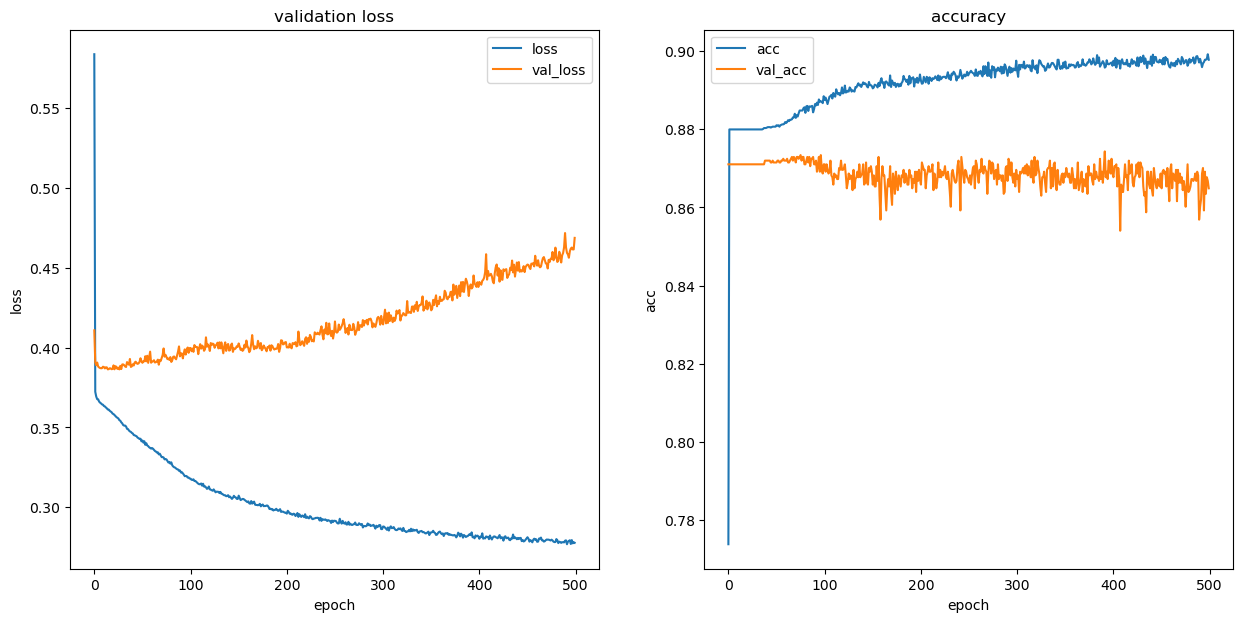

In [54]:
plotDNN(DNNlearn2)

- epoch 횟수가 약 30를 기점으로 정확도가 떨어지기 시작하며 학습 데이터에 대해 과적합 됨을 확인할 수 있음
- epoch = 30 으로 다시 두고 모델 재실행

### DNN 모델 생성 및 실행

In [55]:
# 이 블럭의 코드는 위와 반복되므로 ppt 에 첨부할 필요 없음

# (1) 변수 생성 및 최적화
x612 = x6_1.copy()
y612 = y6_1.copy()

train_x612, val_x612, train_y612, val_y612 = train_test_split(x612, y612, train_size=0.8, random_state=1, stratify=y612)

scaler612 = MinMaxScaler()
scaler612.fit(train_x612)

train_x612 = pd.DataFrame(scaler612.transform(train_x612), columns = train_x612.columns)
val_x612 = pd.DataFrame(scaler612.transform(val_x612), columns = val_x612.columns)

train_y612 = tf.keras.utils.to_categorical(train_y612, num_classes=2)
val_y612 = tf.keras.utils.to_categorical(val_y612, num_classes=2)

# (2) DNN 모델 생성
DNN_epoch30 = getDNN((50,50))
DNN_epoch30.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

#### epoch = 20 으로 두고 모델 실행

In [56]:
DNNlearn_epoch30 = DNN_epoch30.fit(train_x612, train_y612, epochs = 30, batch_size=100, validation_split=0.2, verbose = 1)

Epoch 1/30
85/85 [==============================] - 0s 2ms/step - loss: 0.5433 - acc: 0.7994 - val_loss: 0.3930 - val_acc: 0.8710
Epoch 2/30
85/85 [==============================] - 0s 777us/step - loss: 0.3725 - acc: 0.8800 - val_loss: 0.3913 - val_acc: 0.8710
Epoch 3/30
85/85 [==============================] - 0s 736us/step - loss: 0.3702 - acc: 0.8800 - val_loss: 0.3896 - val_acc: 0.8710
Epoch 4/30
85/85 [==============================] - 0s 870us/step - loss: 0.3687 - acc: 0.8800 - val_loss: 0.3889 - val_acc: 0.8710
Epoch 5/30
85/85 [==============================] - 0s 720us/step - loss: 0.3676 - acc: 0.8800 - val_loss: 0.3882 - val_acc: 0.8710
Epoch 6/30
85/85 [==============================] - 0s 724us/step - loss: 0.3664 - acc: 0.8800 - val_loss: 0.3878 - val_acc: 0.8710
Epoch 7/30
85/85 [==============================] - 0s 714us/step - loss: 0.3654 - acc: 0.8800 - val_loss: 0.3868 - val_acc: 0.8710
Epoch 8/30
85/85 [==============================] - 0s 681us/step - loss: 0.36

In [57]:
DNNevaluate2 = DNN_epoch30.evaluate(val_x612, val_y612)
print("loss = {:.5f} / accuracy = {:.5f}".format(DNNevaluate2[0],DNNevaluate2[1]))

83/83 [==============================] - 0s 381us/step - loss: 0.3809 - acc: 0.8783
loss = 0.38088 / accuracy = 0.87831


### 혼동행렬

83/83 [==============================] - 0s 324us/step


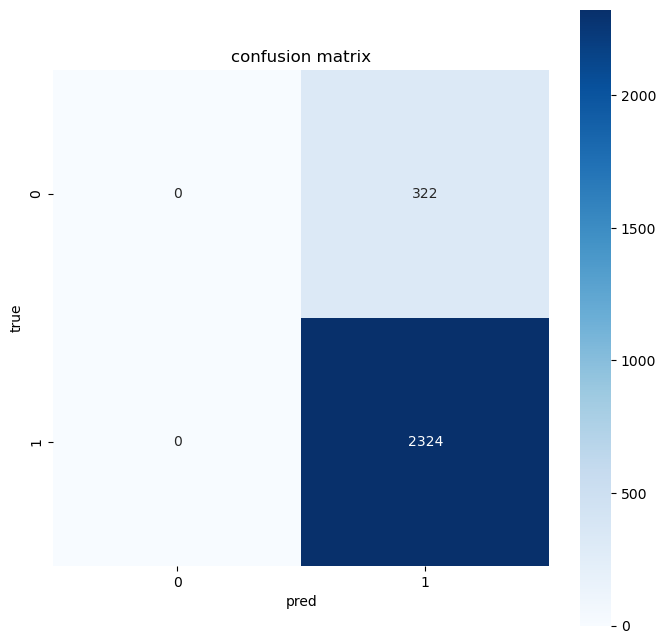

DNN Accuracy for validation data	: 0.87831
DNN Recall for validation data		: 1.00000
DNN F1 score for validation data	: 0.93521


In [58]:
getCFmat(DNN_epoch30, val_x612, val_y612)

## 6-2) CA + DT

### 변수 저장

In [59]:
x62 = x6_2.copy()
y62 = y6_2.copy()

train_x62, val_x62, train_y62, val_y62 = train_test_split(x62, y62, train_size=0.8, random_state=1, stratify=y62)

### 의사결정나무 모델 생성
- GridSearchCV 를 통해서 Decision Tree 모델에 대해 학습 데이터를 이용하여 최적의 하이퍼파라미터 탐색
- 하이퍼 파라미터 후보 : criterion = {gini, entropy} / max_depth = {2, 3, 4, 5, None} / random_state = 1
- 평가 지표 : F1-Score

In [60]:
DT_search2 = tree.DecisionTreeClassifier()

gscv_dt2 = GridSearchCV(estimator=DT_search2, param_grid=param_dt, scoring='f1', cv=5)

gscv_dt2.fit(train_x62, train_y62)

print("F1 score = {:.3f}".format(gscv_dt2.best_score_))
print("parameters =", gscv_dt2.best_params_)

F1 score = 0.935
parameters = {'criterion': 'gini', 'max_depth': 2, 'random_state': 1}


- 최적의 파라미터로 Decision Tree 모델 생성

In [61]:
DT2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=1)

In [62]:
DT2.fit(train_x62, train_y62)

DecisionTreeClassifier(max_depth=2, random_state=1)

[Text(0.5, 0.8333333333333334, 'begin_month <= -6.5\ngini = 0.214\nsamples = 10582\nvalue = [1289, 9293]'),
 Text(0.25, 0.5, 'DAYS_BIRTH_TO_EMPLOYED <= -1.204\ngini = 0.2\nsamples = 9208\nvalue = [1039, 8169]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.156\nsamples = 1007\nvalue = [86, 921]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.205\nsamples = 8201\nvalue = [953, 7248]'),
 Text(0.75, 0.5, 'begin_month <= -0.5\ngini = 0.298\nsamples = 1374\nvalue = [250, 1124]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.288\nsamples = 1291\nvalue = [225, 1066]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.421\nsamples = 83\nvalue = [25, 58]')]

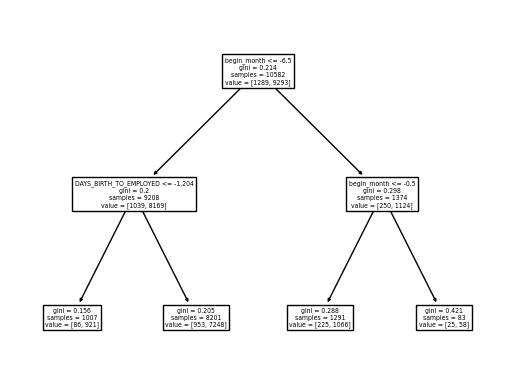

In [63]:
tree.plot_tree(DT2, feature_names = train_x62.columns)

In [64]:
print("Decision Tree Accuracy for validation data\t: {:.5f}".format(accuracy_score(val_y62, DT2.predict(val_x62))))
print("Decision Tree Recall for validation data\t: {:.5f}".format(recall_score(val_y62, DT2.predict(val_x62))))
print("Decision Tree F1 score for validation data\t: {:.5f}".format(f1_score(val_y62, DT2.predict(val_x62))))

Decision Tree Accuracy for validation data	: 0.87831
Decision Tree Recall for validation data	: 1.00000
Decision Tree F1 score for validation data	: 0.93521


## 6-3) CA + LR

### 변수 저장 및 스케일링

In [65]:
x63 = x6_1.copy()
y63 = y6_1.copy()

### Logistic Regression 모델 생성 및 실행

In [66]:
getLR(x63, y63)

Logistic Regression Accuracy for train data	: 0.87819
Logistic Regression Recall for train data	: 1.00000
Logistic Regression F1 score for train data	: 0.93513

Logistic Regression Accuracy for validation data: 0.87831
Logistic Regression Recall for validation data	: 1.00000
Logistic Regression F1 score for validation data: 0.93521


# 7. SOM + DNN / DT / LR

### SOM 모델은 R에서 실행
- train set 을 csv 파일로 저장 후 R의 코드에 이용
- train1.csv : one-hot encoding -> DNN/LR
- train2.csv : label encoding) -> DT

In [67]:
train1.to_csv("train1.csv", mode='w')
train2.to_csv("train2.csv", mode='w')

- 저장된 csv 파일을 이용하여 'som_train.R' 파일 실행
- R 코드에서 얻은 som 결과 파일인 'train1_som.csv', 'train2_som.csv' 파일 저장
- 기존의 train1, train2 파일에, 결과를 'som' 열을 추가하여 각각 train1_som, train2_som 으로 저장

In [68]:
som1 = pd.read_csv("./train1_som.csv")
som2 = pd.read_csv("./train2_som.csv")

som1.rename(columns={'x':'som'}, inplace=True)
som2.rename(columns={'x':'som'}, inplace=True)

train1_som = pd.concat([train1,som1], axis=1)
train2_som = pd.concat([train2,som2], axis=1)

In [69]:
## train set for DNN & LR
x7_1 = train1_som.drop(labels='credit', axis=1, inplace=False)
y7_1 = train1_som['credit']

## train set for DT
x7_2 = train2_som.drop(labels='credit', axis=1, inplace=False)
y7_2 = train2_som['credit']


## 7-1) SOM + DNN

In [70]:
x71 = x7_1.copy()
y71 = y7_1.copy()

train_x71, val_x71, train_y71, val_y71 = train_test_split(x71, y71, train_size=0.8, random_state=1, stratify=y71)

scaler71 = MinMaxScaler()
scaler71.fit(train_x71)

train_x71 = pd.DataFrame(scaler71.transform(train_x71), columns = train_x71.columns)
val_x71 = pd.DataFrame(scaler71.transform(val_x71), columns = val_x71.columns)

In [71]:
train_y71 = tf.keras.utils.to_categorical(train_y71, num_classes=2)
val_y71 = tf.keras.utils.to_categorical(val_y71, num_classes=2)

### DNN 모델 찾기
- 검증 데이터에 대한 정확도를 가장 높일 수 있는 최적의 epoch 횟수 찾기

In [72]:
train_x71.shape

(10582, 50)

In [73]:
DNN3 = getDNN((50,50))
DNN3.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

In [74]:
DNNlearn3 = DNN3.fit(train_x71, train_y71, epochs = 500, batch_size=100, validation_split=0.2, verbose = 1)

Epoch 1/500
85/85 [==============================] - 0s 2ms/step - loss: 0.6407 - acc: 0.6852 - val_loss: 0.4796 - val_acc: 0.8710
Epoch 2/500
85/85 [==============================] - 0s 781us/step - loss: 0.3912 - acc: 0.8800 - val_loss: 0.3887 - val_acc: 0.8710
Epoch 3/500
85/85 [==============================] - 0s 814us/step - loss: 0.3725 - acc: 0.8800 - val_loss: 0.3875 - val_acc: 0.8710
Epoch 4/500
85/85 [==============================] - 0s 729us/step - loss: 0.3704 - acc: 0.8800 - val_loss: 0.3886 - val_acc: 0.8710
Epoch 5/500
85/85 [==============================] - 0s 762us/step - loss: 0.3694 - acc: 0.8800 - val_loss: 0.3878 - val_acc: 0.8710
Epoch 6/500
85/85 [==============================] - 0s 738us/step - loss: 0.3680 - acc: 0.8800 - val_loss: 0.3883 - val_acc: 0.8710
Epoch 7/500
85/85 [==============================] - 0s 740us/step - loss: 0.3669 - acc: 0.8800 - val_loss: 0.3884 - val_acc: 0.8710
Epoch 8/500
85/85 [==============================] - 0s 738us/step - lo

85/85 [==============================] - 0s 712us/step - loss: 0.3134 - acc: 0.8866 - val_loss: 0.4405 - val_acc: 0.8677
Epoch 117/500
85/85 [==============================] - 0s 695us/step - loss: 0.3143 - acc: 0.8858 - val_loss: 0.4378 - val_acc: 0.8673
Epoch 118/500
85/85 [==============================] - 0s 690us/step - loss: 0.3139 - acc: 0.8867 - val_loss: 0.4368 - val_acc: 0.8673
Epoch 119/500
85/85 [==============================] - 0s 709us/step - loss: 0.3133 - acc: 0.8859 - val_loss: 0.4400 - val_acc: 0.8677
Epoch 120/500
85/85 [==============================] - 0s 925us/step - loss: 0.3136 - acc: 0.8862 - val_loss: 0.4401 - val_acc: 0.8677
Epoch 121/500
85/85 [==============================] - 0s 751us/step - loss: 0.3120 - acc: 0.8872 - val_loss: 0.4379 - val_acc: 0.8649
Epoch 122/500
85/85 [==============================] - 0s 714us/step - loss: 0.3114 - acc: 0.8867 - val_loss: 0.4402 - val_acc: 0.8630
Epoch 123/500
85/85 [==============================] - 0s 699us/step 

Epoch 177/500
85/85 [==============================] - 0s 707us/step - loss: 0.2985 - acc: 0.8916 - val_loss: 0.4821 - val_acc: 0.8592
Epoch 178/500
85/85 [==============================] - 0s 696us/step - loss: 0.2990 - acc: 0.8901 - val_loss: 0.4799 - val_acc: 0.8621
Epoch 179/500
85/85 [==============================] - 0s 692us/step - loss: 0.2989 - acc: 0.8897 - val_loss: 0.4777 - val_acc: 0.8616
Epoch 180/500
85/85 [==============================] - 0s 689us/step - loss: 0.2983 - acc: 0.8901 - val_loss: 0.4792 - val_acc: 0.8616
Epoch 181/500
85/85 [==============================] - 0s 715us/step - loss: 0.2981 - acc: 0.8913 - val_loss: 0.4814 - val_acc: 0.8597
Epoch 182/500
85/85 [==============================] - 0s 694us/step - loss: 0.2986 - acc: 0.8908 - val_loss: 0.4806 - val_acc: 0.8611
Epoch 183/500
85/85 [==============================] - 0s 707us/step - loss: 0.2984 - acc: 0.8917 - val_loss: 0.4820 - val_acc: 0.8592
Epoch 184/500
85/85 [==============================] - 

Epoch 238/500
85/85 [==============================] - 0s 721us/step - loss: 0.2886 - acc: 0.8931 - val_loss: 0.5185 - val_acc: 0.8521
Epoch 239/500
85/85 [==============================] - 0s 735us/step - loss: 0.2901 - acc: 0.8931 - val_loss: 0.5240 - val_acc: 0.8451
Epoch 240/500
85/85 [==============================] - 0s 724us/step - loss: 0.2884 - acc: 0.8960 - val_loss: 0.5203 - val_acc: 0.8526
Epoch 241/500
85/85 [==============================] - 0s 709us/step - loss: 0.2882 - acc: 0.8937 - val_loss: 0.5196 - val_acc: 0.8526
Epoch 242/500
85/85 [==============================] - 0s 699us/step - loss: 0.2880 - acc: 0.8938 - val_loss: 0.5179 - val_acc: 0.8517
Epoch 243/500
85/85 [==============================] - 0s 744us/step - loss: 0.2878 - acc: 0.8940 - val_loss: 0.5265 - val_acc: 0.8521
Epoch 244/500
85/85 [==============================] - 0s 714us/step - loss: 0.2877 - acc: 0.8939 - val_loss: 0.5248 - val_acc: 0.8531
Epoch 245/500
85/85 [==============================] - 

Epoch 299/500
85/85 [==============================] - 0s 742us/step - loss: 0.2825 - acc: 0.8965 - val_loss: 0.5524 - val_acc: 0.8413
Epoch 300/500
85/85 [==============================] - 0s 708us/step - loss: 0.2824 - acc: 0.8951 - val_loss: 0.5552 - val_acc: 0.8493
Epoch 301/500
85/85 [==============================] - 0s 719us/step - loss: 0.2814 - acc: 0.8949 - val_loss: 0.5559 - val_acc: 0.8427
Epoch 302/500
85/85 [==============================] - 0s 731us/step - loss: 0.2829 - acc: 0.8952 - val_loss: 0.5500 - val_acc: 0.8460
Epoch 303/500
85/85 [==============================] - 0s 738us/step - loss: 0.2805 - acc: 0.8958 - val_loss: 0.5584 - val_acc: 0.8470
Epoch 304/500
85/85 [==============================] - 0s 703us/step - loss: 0.2817 - acc: 0.8951 - val_loss: 0.5550 - val_acc: 0.8512
Epoch 305/500
85/85 [==============================] - 0s 694us/step - loss: 0.2806 - acc: 0.8959 - val_loss: 0.5515 - val_acc: 0.8484
Epoch 306/500
85/85 [==============================] - 

Epoch 360/500
85/85 [==============================] - 0s 907us/step - loss: 0.2760 - acc: 0.8988 - val_loss: 0.5671 - val_acc: 0.8465
Epoch 361/500
85/85 [==============================] - 0s 741us/step - loss: 0.2769 - acc: 0.8952 - val_loss: 0.5734 - val_acc: 0.8488
Epoch 362/500
85/85 [==============================] - 0s 734us/step - loss: 0.2755 - acc: 0.8989 - val_loss: 0.5873 - val_acc: 0.8271
Epoch 363/500
85/85 [==============================] - 0s 771us/step - loss: 0.2769 - acc: 0.8970 - val_loss: 0.5729 - val_acc: 0.8413
Epoch 364/500
85/85 [==============================] - 0s 733us/step - loss: 0.2758 - acc: 0.8982 - val_loss: 0.5801 - val_acc: 0.8351
Epoch 365/500
85/85 [==============================] - 0s 727us/step - loss: 0.2767 - acc: 0.8971 - val_loss: 0.5776 - val_acc: 0.8403
Epoch 366/500
85/85 [==============================] - 0s 711us/step - loss: 0.2752 - acc: 0.8988 - val_loss: 0.5773 - val_acc: 0.8366
Epoch 367/500
85/85 [==============================] - 

Epoch 421/500
85/85 [==============================] - 0s 689us/step - loss: 0.2713 - acc: 0.8969 - val_loss: 0.5923 - val_acc: 0.8474
Epoch 422/500
85/85 [==============================] - 0s 692us/step - loss: 0.2734 - acc: 0.8985 - val_loss: 0.5921 - val_acc: 0.8441
Epoch 423/500
85/85 [==============================] - 0s 736us/step - loss: 0.2729 - acc: 0.8989 - val_loss: 0.5936 - val_acc: 0.8389
Epoch 424/500
85/85 [==============================] - 0s 707us/step - loss: 0.2725 - acc: 0.8983 - val_loss: 0.5897 - val_acc: 0.8432
Epoch 425/500
85/85 [==============================] - 0s 698us/step - loss: 0.2726 - acc: 0.8984 - val_loss: 0.6017 - val_acc: 0.8366
Epoch 426/500
85/85 [==============================] - 0s 693us/step - loss: 0.2738 - acc: 0.8984 - val_loss: 0.5873 - val_acc: 0.8441
Epoch 427/500
85/85 [==============================] - 0s 758us/step - loss: 0.2730 - acc: 0.8981 - val_loss: 0.5942 - val_acc: 0.8361
Epoch 428/500
85/85 [==============================] - 

Epoch 482/500
85/85 [==============================] - 0s 741us/step - loss: 0.2698 - acc: 0.8994 - val_loss: 0.6090 - val_acc: 0.8474
Epoch 483/500
85/85 [==============================] - 0s 701us/step - loss: 0.2683 - acc: 0.8992 - val_loss: 0.6046 - val_acc: 0.8432
Epoch 484/500
85/85 [==============================] - 0s 707us/step - loss: 0.2694 - acc: 0.8991 - val_loss: 0.6014 - val_acc: 0.8436
Epoch 485/500
85/85 [==============================] - 0s 696us/step - loss: 0.2687 - acc: 0.8998 - val_loss: 0.6070 - val_acc: 0.8455
Epoch 486/500
85/85 [==============================] - 0s 699us/step - loss: 0.2690 - acc: 0.8981 - val_loss: 0.6150 - val_acc: 0.8408
Epoch 487/500
85/85 [==============================] - 0s 728us/step - loss: 0.2684 - acc: 0.8997 - val_loss: 0.6212 - val_acc: 0.8389
Epoch 488/500
85/85 [==============================] - 0s 689us/step - loss: 0.2701 - acc: 0.8979 - val_loss: 0.6122 - val_acc: 0.8436
Epoch 489/500
85/85 [==============================] - 

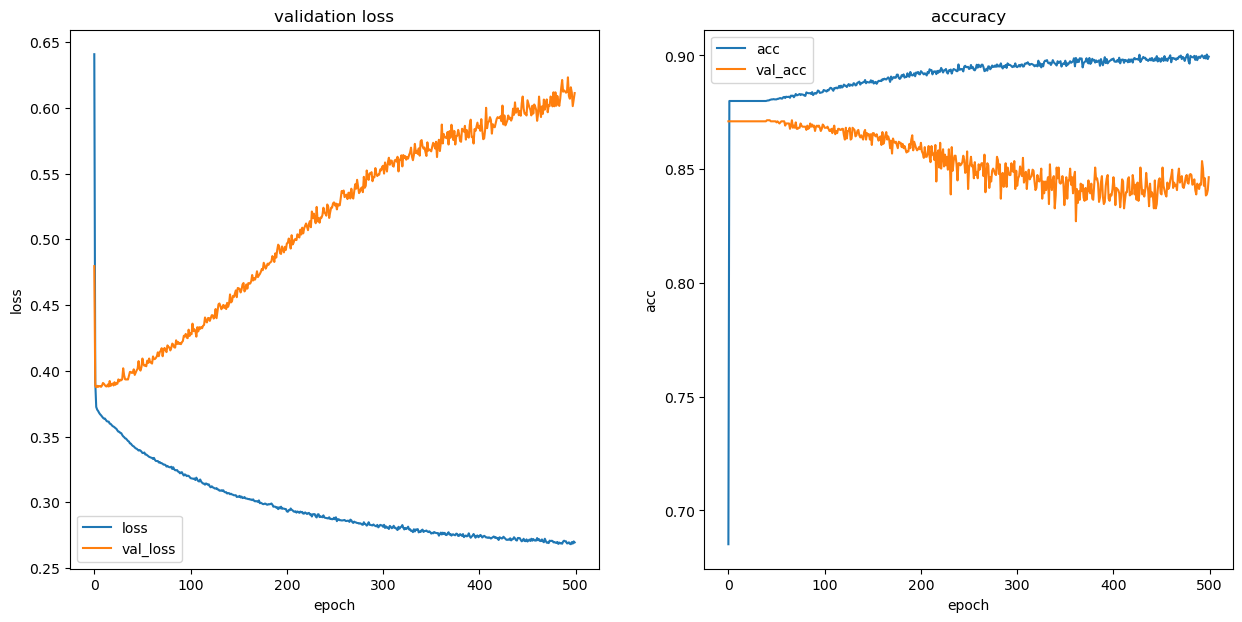

In [75]:
plotDNN(DNNlearn3)

- epoch 횟수가 약 20회를 넘는 시점부터 학습 데이터에 대해 과적합 됨을 확인할 수 있음
- epoch = 20 으로 다시 두고 모델 재실행

### DNN 모델 생성 및 실행

In [76]:
# 이 블럭의 코드는 위와 반복되므로 ppt 에 첨부할 필요 없음

# (1) 변수 생성 및 최적화
x712 = x7_1.copy()
y712 = y7_1.copy()

train_x712, val_x712, train_y712, val_y712 = train_test_split(x712, y712, train_size=0.8, random_state=1, stratify=y712)

scaler712 = MinMaxScaler()
scaler712.fit(train_x712)

train_x712 = pd.DataFrame(scaler712.transform(train_x712), columns = train_x712.columns)
val_x712 = pd.DataFrame(scaler712.transform(val_x712), columns = val_x712.columns)

train_y712 = tf.keras.utils.to_categorical(train_y712, num_classes=2)
val_y712 = tf.keras.utils.to_categorical(val_y712, num_classes=2)

# (2) DNN 모델 생성
DNN_epoch20 = getDNN((50,50))
DNN_epoch20.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

#### epoch = 30 으로 두고 모델 실행

In [77]:
DNNlearn_epoch20 = DNN_epoch20.fit(train_x712, train_y712, epochs = 20, batch_size=100, validation_split=0.2, verbose = 1)

Epoch 1/20
85/85 [==============================] - 0s 1ms/step - loss: 0.5907 - acc: 0.7640 - val_loss: 0.4113 - val_acc: 0.8710
Epoch 2/20
85/85 [==============================] - 0s 707us/step - loss: 0.3741 - acc: 0.8800 - val_loss: 0.3911 - val_acc: 0.8710
Epoch 3/20
85/85 [==============================] - 0s 721us/step - loss: 0.3698 - acc: 0.8800 - val_loss: 0.3903 - val_acc: 0.8710
Epoch 4/20
85/85 [==============================] - 0s 711us/step - loss: 0.3679 - acc: 0.8800 - val_loss: 0.3894 - val_acc: 0.8710
Epoch 5/20
85/85 [==============================] - 0s 697us/step - loss: 0.3665 - acc: 0.8800 - val_loss: 0.3897 - val_acc: 0.8710
Epoch 6/20
85/85 [==============================] - 0s 689us/step - loss: 0.3655 - acc: 0.8800 - val_loss: 0.3900 - val_acc: 0.8710
Epoch 7/20
85/85 [==============================] - 0s 689us/step - loss: 0.3646 - acc: 0.8800 - val_loss: 0.3886 - val_acc: 0.8710
Epoch 8/20
85/85 [==============================] - 0s 696us/step - loss: 0.36

In [78]:
DNNevaluate3 = DNN_epoch20.evaluate(val_x712, val_y712)
print("loss = {:.5f} / accuracy = {:.5f}".format(DNNevaluate3[0],DNNevaluate3[1]))

83/83 [==============================] - 0s 362us/step - loss: 0.3704 - acc: 0.8783
loss = 0.37038 / accuracy = 0.87831


### 혼동행렬

83/83 [==============================] - 0s 315us/step


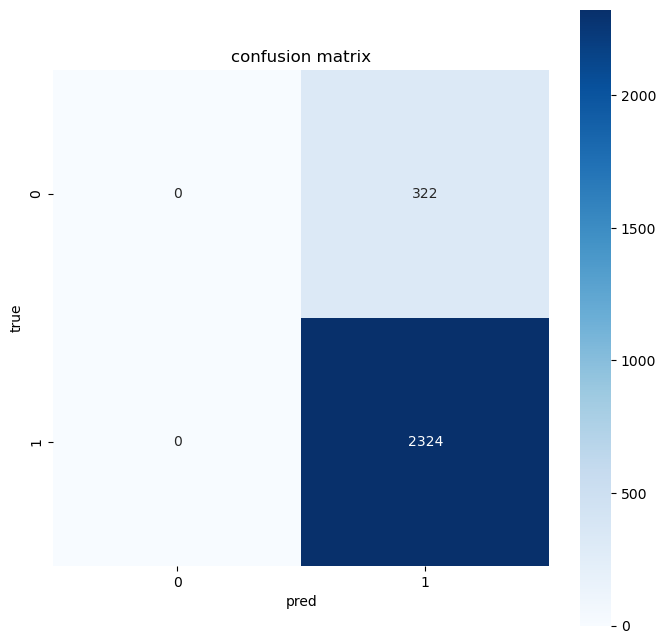

DNN Accuracy for validation data	: 0.87831
DNN Recall for validation data		: 1.00000
DNN F1 score for validation data	: 0.93521


In [79]:
getCFmat(DNN_epoch20, val_x712, val_y712)

## 7-2) SOM + DT

### 변수 저장

In [80]:
x72 = x7_2.copy()
y72 = y7_2.copy()

train_x72, val_x72, train_y72, val_y72 = train_test_split(x72, y72, train_size=0.8, random_state=1, stratify=y72)

### 의사결정나무 모델 생성
- GridSearchCV 를 통해서 Decision Tree 모델에 대해 학습 데이터를 이용하여 최적의 하이퍼파라미터 탐색
- 하이퍼 파라미터 후보 : criterion = {gini, entropy} / max_depth = {2, 3, 4, 5, None} / random_state = 1
- 평가 지표 : F1-Score

In [81]:
DT_search3 = tree.DecisionTreeClassifier()

gscv_dt3 = GridSearchCV(estimator=DT_search3, param_grid=param_dt, scoring='f1', cv=5)

gscv_dt3.fit(train_x72, train_y72)

print("F1 score = {:.5f}".format(gscv_dt3.best_score_))
print("parameters =", gscv_dt3.best_params_)

F1 score = 0.99523
parameters = {'criterion': 'gini', 'max_depth': 5, 'random_state': 1}


- 최적의 파라미터로 Decision Tree 모델 생성

In [82]:
DT3 = tree.DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1)

In [83]:
DT3.fit(train_x72, train_y72)

DecisionTreeClassifier(max_depth=5, random_state=1)

[Text(0.5646551724137931, 0.9166666666666666, 'som <= 15.5\ngini = 0.214\nsamples = 10582\nvalue = [1289, 9293]'),
 Text(0.3103448275862069, 0.75, 'som <= 13.5\ngini = 0.301\nsamples = 6371\nvalue = [1178, 5193]'),
 Text(0.27586206896551724, 0.5833333333333334, 'som <= 8.5\ngini = 0.112\nsamples = 5522\nvalue = [329, 5193]'),
 Text(0.13793103448275862, 0.4166666666666667, 'house_type <= 3.5\ngini = 0.026\nsamples = 3555\nvalue = [46, 3509]'),
 Text(0.06896551724137931, 0.25, 'family_type <= 3.5\ngini = 0.001\nsamples = 3076\nvalue = [2, 3074]'),
 Text(0.034482758620689655, 0.08333333333333333, 'gini = 0.0\nsamples = 2687\nvalue = [0, 2687]'),
 Text(0.10344827586206896, 0.08333333333333333, 'gini = 0.01\nsamples = 389\nvalue = [2, 387]'),
 Text(0.20689655172413793, 0.25, 'income_total <= 56250.0\ngini = 0.167\nsamples = 479\nvalue = [44, 435]'),
 Text(0.1724137931034483, 0.08333333333333333, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.2413793103448276, 0.08333333333333333, 'gini

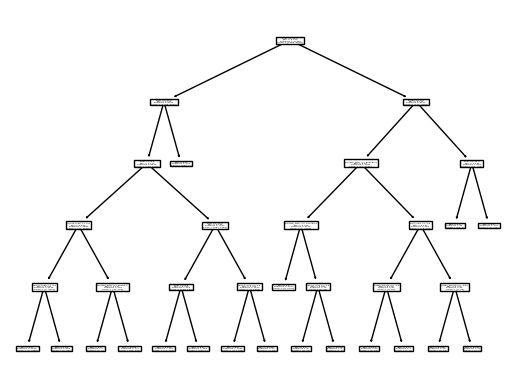

In [84]:
tree.plot_tree(DT3, feature_names = train_x72.columns)

In [85]:
print("Decision Tree Accuracy for validation data\t: {:.5f}".format(accuracy_score(val_y72, DT3.predict(val_x72))))
print("Decision Tree Recall for validation data\t: {:.5f}".format(recall_score(val_y72, DT3.predict(val_x72))))
print("Decision Tree F1 score for validation data\t: {:.5f}".format(f1_score(val_y72, DT3.predict(val_x72))))

Decision Tree Accuracy for validation data	: 0.98753
Decision Tree Recall for validation data	: 0.99656
Decision Tree F1 score for validation data	: 0.99293


## 7-3) SOM + LR

### 변수 저장

In [86]:
x73 = x7_1.copy()
y73 = y7_1.copy()

### Logistic Regression 모델 생성 및 실행

In [87]:
getLR(x73, y73)

Logistic Regression Accuracy for train data	: 0.87819
Logistic Regression Recall for train data	: 1.00000
Logistic Regression F1 score for train data	: 0.93513

Logistic Regression Accuracy for validation data: 0.87831
Logistic Regression Recall for validation data	: 1.00000
Logistic Regression F1 score for validation data: 0.93521


# 8. Test Data 예측
- 가장 성능이 좋았던 SOM+DT 모델을 이용하여 test data 에 대해 credit 예측
- accuracy, recall, f1 score 가 균형적으로 높고, 특히 종합 지표인 f1 score 가 높은 모델이 가장 좋은 모델이라고 판단하였음

## (1) Test Data 전처리
- train data 와 같은 방식으로 test data 전처리

In [88]:
## (1) 결측치 확인 및 최빈값으로 대체
test_data.fillna(test_data['occyp_type'].mode()[0], inplace=True)

## (2) 불필요한 변수 제거 (FLAG_MOBIL)
test_data.drop(labels='FLAG_MOBIL', axis=1, inplace=True)

## (3) 범주형 변수 처리 - [1] binary class
test_data['gender'] = test_data['gender'].map({'F':0, 'M':1})
test_data['car'] = train['car'].map({'Y':1, 'N':0})
test_data['reality'] = train['reality'].map({'Y':1, 'N':0})

## (4-1) 다중공선성 제거 (child_num 제거)
test_data.drop(labels='child_num', axis=1, inplace=True)

## (4-2) 다중공선성 제거 (PCA)
pca_x2 = test_data[['DAYS_BIRTH', 'DAYS_EMPLOYED']].values
pca_x2 = StandardScaler().fit_transform(pca_x2)

pca2 = PCA(n_components=1)
pca_train2 = pca.fit_transform(pca_x2)

test_data.drop(labels=['DAYS_BIRTH','DAYS_EMPLOYED'], axis=1, inplace=True)
test_data['DAYS_BIRTH_TO_EMPLOYED'] = pca_train2

## (5) 범주형 변수 처리 - [2] multi class
## (5-1) One-Hot Encoding
test_data1 = pd.get_dummies(test_data, columns = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])

## (5-2) Label Encoding
test_data2 = test_data.copy()
for col in list(test_data2.columns):
    le2 = LabelEncoder()
    test_data2[col] = le2.fit_transform(test_data2[col])

## (2) SOM 진행
- train data 와 마찬가지로 전처리한 test_data 를 csv 파일로 저장하여 R 에서 SOM 모델을 실행한 후, 결과 값을 받아 test2_som 이라는 dataframe 에 기존의 test_data 와 som 결과를 합쳐 새롭게 저장

In [89]:
test_data2.to_csv("test_data2.csv", mode='w')

- 저장된 csv 파일을 이용하여 'som_test.R' 파일 실행
- R 코드에서 얻은 som 결과 파일인 'test_som.csv' 파일 저장
- 기존의 test_data2 파일에, 결과를 'som' 열을 추가하여 각각 test2_som으로 저장

In [90]:
somtest= pd.read_csv("./test_som.csv")
somtest.rename(columns={'x':'som'}, inplace=True)
test2_som = pd.concat([test_data2, somtest], axis=1)

## (3) SOM + DT 모델로 Test Data 에 대한 credit 예측

In [91]:
TestPred = DT3.predict(test2_som)

In [92]:
test_label['credit'] = TestPred

In [93]:
test_label.to_csv("test_label.csv", mode='w')